## Setup

In [ ]:
!pip install -q transformers==4.37.2
!pip install numba

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import mixed_precision

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from numba import cuda

import sklearn as sk
import os
import nltk
from nltk.data import find
import pandas as pd
import gc

import matplotlib.pyplot as plt

import re

## Load datasets

In [ ]:
## Load datasets
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
model_checkpoints_path = '/content/drive/My Drive/ds266proj/model_checkpoints'

# Read data from to Google Drive
hs_all_data = pd.read_csv('/content/drive/My Drive/ds266proj/hs_cards_data_text.csv')
nr_all_data = pd.read_csv('/content/drive/My Drive/ds266proj/nr_cards_data_text.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## CODE FOR TRAIN AND TEST SPLITS
##===========================================================

def splitTrainTest(dataset,
                   label,
                   test_ratio = 0.3):

  # Set up the modeling dataset and classification label
  modeling_df = dataset.copy()
  classes = modeling_df[label].unique().tolist()
  print(f"Label classes: {classes}")
  # Convert the label to a numeric value
  modeling_df.loc[:, label] = modeling_df[label].map(classes.index)

  # Split into training and test data
  np.random.seed(2319)
  test_indices = np.random.rand(len(modeling_df)) < test_ratio
  print("{} examples in training, {} examples for testing.".format(
    len(modeling_df[~test_indices]), len(modeling_df[test_indices])))

  return modeling_df[~test_indices], modeling_df[test_indices]

hs_train, hs_test = splitTrainTest(hs_all_data, label = 'classes')
nr_train, nr_test = splitTrainTest(nr_all_data, label = 'faction_code')

Label classes: ['PRIEST', 'WARRIOR', 'WARLOCK', 'SHAMAN', 'DRUID', 'PALADIN', 'MAGE', 'HUNTER', 'ROGUE', 'DEMONHUNTER', 'DEATHKNIGHT', 'NEUTRAL']
5234 examples in training, 2291 examples for testing.
Label classes: ['neutral-corp', 'neutral-runner', 'weyland-consortium', 'nbn', 'jinteki', 'haas-bioroid', 'shaper', 'criminal', 'anarch']
1495 examples in training, 628 examples for testing.


In [ ]:
from transformers import BertTokenizer, TFBertModel, BertModel, AutoTokenizer
from transformers import logging
logging.set_verbosity_error()

In [ ]:
MAX_SEQ_LENGTH = 512
checkpoint = 'bert-base-cased'

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Define functions for modeling

In [ ]:
## Simplistic BERT model creation
## Tensorflow version
##-----------------------------------------------------
def create_bert_classification_model(bert_model,
                                     checkpoint_name = 'DEFAULT',
                                     model_checkpoints_path = '/content/drive/My Drive/ds266proj/model_checkpoints/',
                                     num_train_layers = 0,
                                     retrain_layers = None,
                                     hidden_size = 200,
                                     num_classes = 12,
                                     dropout = 0.3,
                                     chkpt_period = 1,
                                     learning_rate = 0.00005):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes
    """
    if num_train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False
    elif num_train_layers == 12 and retrain_layers is None:
        # Train all layers of the BERT model
        bert_model.trainable = True
    else:
        # Restrict training to the num_train_layers outer transformer layers
        if retrain_layers is not None:
          print('retrain layers: ', retrain_layers)
        else:
          retrain_layers = []
          for retrain_layer_number in range(num_train_layers):
              layer_code = '_' + str(11 - retrain_layer_number)
              retrain_layers.append(layer_code)
          print('retrain layers: ', retrain_layers)

        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                # print('freezing: ', w.name)
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    ## Set up the BERT model; this will use the CLS token input
    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}
    bert_out = bert_model(bert_inputs)
    cls_token = bert_out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification')(hidden)
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss='sparse_categorical_crossentropy',
                                 metrics='accuracy')

    ## Set up the checkpointing for the model
    checkpoint_filepath = model_checkpoints_path + checkpoint_name + '_tfweights.{epoch:02d}-{val_accuracy:.2f}.hdf5'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, period=chkpt_period)

    return classification_model, model_checkpoint_callback

## Paramteriz Data For Models

In [ ]:
## Set up the model inputs
def genBERTInputs(train_data, test_data, desc_field, label_field, return_tensors):
  # Tokenize the training and test data
  x_train = bert_tokenizer(train_data[desc_field].tolist(),
                           padding = "max_length",
                           truncation = True,
                           max_length = MAX_SEQ_LENGTH,
                           return_tensors = return_tensors)
  x_test = bert_tokenizer(test_data[desc_field].tolist(),
                          padding = "max_length",
                          truncation = True,
                          max_length = MAX_SEQ_LENGTH,
                          return_tensors = return_tensors)
  # Return array versions of the labels
  y_train = np.array(train_data[label_field].tolist())
  y_test = np.array(test_data[label_field].tolist())
  # Return all data
  return x_train, x_test, y_train, y_test

# Create the datasets
x_hs_train_tf, x_hs_test_tf, y_hs_train_tf, y_hs_test_tf = genBERTInputs(hs_train, hs_test, 'description', 'classes', 'tf')
x_nr_train_tf, x_nr_test_tf, y_nr_train_tf, y_nr_test_tf = genBERTInputs(nr_train, nr_test, 'description', 'faction_code', 'tf')

## Run Models

### Base Models

#### BERT, TF

In [ ]:
## Parametrize
EPOCHS = 2
tf_bert_model = TFBertModel.from_pretrained(checkpoint)

hs_bert_1, hs_bert_1_chkpt = create_bert_classification_model(tf_bert_model, checkpoint_name = 'BERT_base_HS', num_train_layers=0, chkpt_period = EPOCHS)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
## Train the model
hs_bert_1_history = hs_bert_1.fit(
    [x_hs_train_tf.input_ids, x_hs_train_tf.token_type_ids, x_hs_train_tf.attention_mask],
    y_hs_train_tf,
    validation_data=([x_hs_test_tf.input_ids, x_hs_test_tf.token_type_ids, x_hs_test_tf.attention_mask], y_hs_test_tf),
    batch_size=32,
    epochs=EPOCHS,
    callbacks=[hs_bert_1_chkpt]
)

Epoch 1/2
164/164 [==============================] - 136s 722ms/step - loss: 2.5890 - accuracy: 0.0940 - val_loss: 2.4481 - val_accuracy: 0.1336
Epoch 2/2
164/164 [==============================] - 104s 634ms/step - loss: 2.5082 - accuracy: 0.0974 - val_loss: 2.4381 - val_accuracy: 0.1279


In [ ]:
# Clear out the previous model to make RAM space for a bigger pass
# Delete the variable holding the NLP model
del tf_bert_model
del hs_bert_1
del hs_bert_1_chkpt
gc.collect()

In [ ]:
## Parametrize
EPOCHS = 2
tf_bert_model = TFBertModel.from_pretrained(checkpoint)

nr_bert_1, nr_bert_1_chkpt = create_bert_classification_model(tf_bert_model, checkpoint_name = 'BERT_base_NR', num_train_layers=0, chkpt_period = EPOCHS)

In [ ]:
## Train the model
nr_bert_1_history = nr_bert_1.fit(
    [x_nr_train_tf.input_ids, x_nr_train_tf.token_type_ids, x_nr_train_tf.attention_mask],
    y_nr_train_tf,
    validation_data=([x_nr_test_tf.input_ids, x_nr_test_tf.token_type_ids, x_nr_test_tf.attention_mask], y_nr_test_tf),
    batch_size=32,
    epochs=EPOCHS,
    callbacks=[nr_bert_1_chkpt]
)

Epoch 1/2
47/47 [==============================] - 49s 740ms/step - loss: 2.6914 - accuracy: 0.0963 - val_loss: 2.3771 - val_accuracy: 0.1003
Epoch 2/2
47/47 [==============================] - 33s 697ms/step - loss: 2.4229 - accuracy: 0.1144 - val_loss: 2.2623 - val_accuracy: 0.1561


In [ ]:
# Clear out the previous model to make RAM space for a bigger pass
# Delete the variable holding the NLP model
del tf_bert_model
del nr_bert_1
del nr_bert_1_chkpt
gc.collect()

19041

#### Bigger Bert, TF

In [ ]:
# Train the first layer and allow more epochs -- better?
tf_bert_model = TFBertModel.from_pretrained(checkpoint)
hs_bert_2, hs_bert_2_chkpt = create_bert_classification_model(tf_bert_model, checkpoint_name = 'BERT_shallow_train_HS', num_train_layers=1)

retrain layers:  ['_11']


In [ ]:
hs_bert_2_history = hs_bert_2.fit(
    [x_hs_train_tf.input_ids, x_hs_train_tf.token_type_ids, x_hs_train_tf.attention_mask],
    y_hs_train_tf,
    validation_data=([x_hs_test_tf.input_ids, x_hs_test_tf.token_type_ids, x_hs_test_tf.attention_mask], y_hs_test_tf),
    batch_size=32,
    epochs=4,
    callbacks=[hs_bert_2_chkpt]
)

Epoch 1/4


164/164 [==============================] - 143s 803ms/step - loss: 2.4197 - accuracy: 0.1555 - val_loss: 2.0905 - val_accuracy: 0.3195
Epoch 2/4
164/164 [==============================] - 124s 756ms/step - loss: 1.9314 - accuracy: 0.3452 - val_loss: 1.6383 - val_accuracy: 0.4461
Epoch 3/4
164/164 [==============================] - 111s 675ms/step - loss: 1.6383 - accuracy: 0.4413 - val_loss: 1.4556 - val_accuracy: 0.5155
Epoch 4/4
164/164 [==============================] - 110s 674ms/step - loss: 1.4599 - accuracy: 0.5094 - val_loss: 1.3192 - val_accuracy: 0.5648


In [ ]:
del tf_bert_model
del hs_bert_2
del hs_bert_2_chkpt
gc.collect()

18993

In [ ]:
# Train the first layer and allow more epochs -- better?
tf_bert_model = TFBertModel.from_pretrained(checkpoint)
nr_bert_2, nr_bert_2_chkpt = create_bert_classification_model(tf_bert_model, checkpoint_name = 'BERT_shallow_train_NR', num_train_layers=1)

retrain layers:  ['_11']


In [ ]:
nr_bert_2_history = nr_bert_2.fit(
    [x_nr_train_tf.input_ids, x_nr_train_tf.token_type_ids, x_nr_train_tf.attention_mask],
    y_nr_train_tf,
    validation_data=([x_nr_test_tf.input_ids, x_nr_test_tf.token_type_ids, x_nr_test_tf.attention_mask], y_nr_test_tf),
    batch_size=32,
    epochs=4,
    callbacks=[nr_bert_2_chkpt]
)

Epoch 1/4


47/47 [==============================] - 55s 918ms/step - loss: 2.3341 - accuracy: 0.1291 - val_loss: 2.1658 - val_accuracy: 0.1720
Epoch 2/4
47/47 [==============================] - 36s 783ms/step - loss: 2.1310 - accuracy: 0.2047 - val_loss: 1.8892 - val_accuracy: 0.2627
Epoch 3/4
47/47 [==============================] - 35s 757ms/step - loss: 1.8083 - accuracy: 0.2916 - val_loss: 1.5180 - val_accuracy: 0.4124
Epoch 4/4
47/47 [==============================] - 33s 702ms/step - loss: 1.5211 - accuracy: 0.4007 - val_loss: 1.2926 - val_accuracy: 0.4825


In [ ]:
del tf_bert_model
del nr_bert_2
del nr_bert_2_chkpt
gc.collect()

18985

In [ ]:
# Train the first layer and allow more epochs -- better?
tf_bert_model = TFBertModel.from_pretrained(checkpoint)
hs_bert_3, hs_bert_3_chkpt = create_bert_classification_model(tf_bert_model, checkpoint_name = 'BERT_medium_train_HS', num_train_layers=4)

retrain layers:  ['_11', '_10', '_9', '_8']


In [ ]:
hs_bert_3_history = hs_bert_3.fit(
    [x_hs_train_tf.input_ids, x_hs_train_tf.token_type_ids, x_hs_train_tf.attention_mask],
    y_hs_train_tf,
    validation_data=([x_hs_test_tf.input_ids, x_hs_test_tf.token_type_ids, x_hs_test_tf.attention_mask], y_hs_test_tf),
    batch_size=32,
    epochs=8,
    callbacks=[hs_bert_3_chkpt]
)

Epoch 1/8


164/164 [==============================] - 165s 899ms/step - loss: 2.2793 - accuracy: 0.2184 - val_loss: 1.7090 - val_accuracy: 0.4435
Epoch 2/8
164/164 [==============================] - 152s 929ms/step - loss: 1.5939 - accuracy: 0.4561 - val_loss: 1.3505 - val_accuracy: 0.5500
Epoch 3/8
164/164 [==============================] - 152s 928ms/step - loss: 1.2089 - accuracy: 0.5894 - val_loss: 1.1615 - val_accuracy: 0.6072
Epoch 4/8
164/164 [==============================] - 152s 929ms/step - loss: 0.9503 - accuracy: 0.6741 - val_loss: 1.0311 - val_accuracy: 0.6748
Epoch 5/8
164/164 [==============================] - 152s 928ms/step - loss: 0.7078 - accuracy: 0.7606 - val_loss: 0.9753 - val_accuracy: 0.7041
Epoch 6/8
164/164 [==============================] - 152s 928ms/step - loss: 0.5521 - accuracy: 0.8172 - val_loss: 0.9525 - val_accuracy: 0.7359
Epoch 7/8
164/164 [==============================] - 152s 929ms/step - loss: 0.4204 - accuracy: 0.8661 - val_loss: 0.9269 - val_accuracy: 0.

In [ ]:
del tf_bert_model
del hs_bert_3
del hs_bert_3_chkpt
gc.collect()

In [ ]:
# Train the first layer and allow more epochs -- better?
tf_bert_model = TFBertModel.from_pretrained(checkpoint)
nr_bert_3, nr_bert_3_chkpt = create_bert_classification_model(tf_bert_model, checkpoint_name = 'BERT_medium_train_NR', num_train_layers=4)

retrain layers:  ['_11', '_10', '_9', '_8']


In [ ]:
nr_bert_3_history = nr_bert_3.fit(
    [x_nr_train_tf.input_ids, x_nr_train_tf.token_type_ids, x_nr_train_tf.attention_mask],
    y_nr_train_tf,
    validation_data=([x_nr_test_tf.input_ids, x_nr_test_tf.token_type_ids, x_nr_test_tf.attention_mask], y_nr_test_tf),
    batch_size=32,
    epochs=8,
    callbacks=[nr_bert_3_chkpt]
)

Epoch 1/8


47/47 [==============================] - 71s 1s/step - loss: 2.2541 - accuracy: 0.1505 - val_loss: 1.9505 - val_accuracy: 0.2357
Epoch 2/8
47/47 [==============================] - 43s 928ms/step - loss: 1.7506 - accuracy: 0.3064 - val_loss: 1.3070 - val_accuracy: 0.4841
Epoch 3/8
47/47 [==============================] - 44s 933ms/step - loss: 1.2845 - accuracy: 0.4930 - val_loss: 1.0639 - val_accuracy: 0.5525
Epoch 4/8
47/47 [==============================] - 43s 926ms/step - loss: 1.0117 - accuracy: 0.6054 - val_loss: 0.9477 - val_accuracy: 0.6146
Epoch 5/8
47/47 [==============================] - 44s 938ms/step - loss: 0.8653 - accuracy: 0.6649 - val_loss: 0.8651 - val_accuracy: 0.6465
Epoch 6/8
47/47 [==============================] - 43s 930ms/step - loss: 0.7104 - accuracy: 0.7237 - val_loss: 0.9314 - val_accuracy: 0.6640
Epoch 7/8
47/47 [==============================] - 43s 927ms/step - loss: 0.5537 - accuracy: 0.7860 - val_loss: 0.9169 - val_accuracy: 0.6959
Epoch 8/8
47/47 [==

In [ ]:
del tf_bert_model
del nr_bert_3
del nr_bert_3_chkpt
del nr_bert_3_history
gc.collect()

1689

#### Final Model Spec

In [ ]:
# Train the first layer and allow more epochs -- better?
tf_bert_model = TFBertModel.from_pretrained(checkpoint)
hs_bert_4, hs_bert_4_chkpt = create_bert_classification_model(tf_bert_model, num_classes = 12, checkpoint_name = 'BERT_full_train_HS', num_train_layers=12)

In [ ]:
hs_bert_4_history = hs_bert_4.fit(
    [x_hs_train_tf.input_ids, x_hs_train_tf.token_type_ids, x_hs_train_tf.attention_mask],
    y_hs_train_tf,
    validation_data=([x_hs_test_tf.input_ids, x_hs_test_tf.token_type_ids, x_hs_test_tf.attention_mask], y_hs_test_tf),
    batch_size=16,
    epochs=8,
    callbacks=[hs_bert_4_chkpt]
)

Epoch 1/8


328/328 [==============================] - 282s 714ms/step - loss: 2.1278 - accuracy: 0.2702 - val_loss: 1.5418 - val_accuracy: 0.4989
Epoch 2/8
328/328 [==============================] - 244s 744ms/step - loss: 1.3124 - accuracy: 0.5699 - val_loss: 1.1476 - val_accuracy: 0.6272
Epoch 3/8
328/328 [==============================] - 241s 735ms/step - loss: 0.8547 - accuracy: 0.7314 - val_loss: 1.0187 - val_accuracy: 0.7006
Epoch 4/8
328/328 [==============================] - 241s 735ms/step - loss: 0.5082 - accuracy: 0.8494 - val_loss: 0.9858 - val_accuracy: 0.7372
Epoch 5/8
328/328 [==============================] - 241s 734ms/step - loss: 0.3423 - accuracy: 0.8955 - val_loss: 0.9764 - val_accuracy: 0.7625
Epoch 6/8
328/328 [==============================] - 243s 741ms/step - loss: 0.2418 - accuracy: 0.9291 - val_loss: 1.1105 - val_accuracy: 0.7822
Epoch 7/8
328/328 [==============================] - 240s 733ms/step - loss: 0.1941 - accuracy: 0.9400 - val_loss: 1.0842 - val_accuracy: 0.

In [ ]:
# Clear the GPU cache
device = cuda.get_current_device()
device.reset()

In [ ]:
# Train the first layer and allow more epochs -- better?
tf_bert_model = TFBertModel.from_pretrained(checkpoint)
nr_bert_4, nr_bert_4_chkpt = create_bert_classification_model(tf_bert_model, num_classes = 9, checkpoint_name = 'BERT_full_train_NR', num_train_layers=12)

In [ ]:
nr_bert_4_history = nr_bert_4.fit(
    [x_nr_train_tf.input_ids, x_nr_train_tf.token_type_ids, x_nr_train_tf.attention_mask],
    y_nr_train_tf,
    validation_data=([x_nr_test_tf.input_ids, x_nr_test_tf.token_type_ids, x_nr_test_tf.attention_mask], y_nr_test_tf),
    batch_size=16,
    epochs=8,
    callbacks=[nr_bert_4_chkpt]
)

Epoch 1/8


94/94 [==============================] - 127s 822ms/step - loss: 1.8566 - accuracy: 0.2441 - val_loss: 1.2562 - val_accuracy: 0.4602
Epoch 2/8
94/94 [==============================] - 69s 732ms/step - loss: 1.1898 - accuracy: 0.5070 - val_loss: 1.0545 - val_accuracy: 0.5987
Epoch 3/8
94/94 [==============================] - 67s 713ms/step - loss: 0.9239 - accuracy: 0.6361 - val_loss: 0.9020 - val_accuracy: 0.6146
Epoch 4/8
94/94 [==============================] - 69s 732ms/step - loss: 0.6367 - accuracy: 0.7605 - val_loss: 0.9319 - val_accuracy: 0.7086
Epoch 5/8
94/94 [==============================] - 69s 731ms/step - loss: 0.4037 - accuracy: 0.8508 - val_loss: 0.9360 - val_accuracy: 0.7118
Epoch 6/8
94/94 [==============================] - 69s 733ms/step - loss: 0.2442 - accuracy: 0.9217 - val_loss: 1.1863 - val_accuracy: 0.6895
Epoch 7/8
94/94 [==============================] - 69s 738ms/step - loss: 0.2272 - accuracy: 0.9231 - val_loss: 1.5496 - val_accuracy: 0.6162
Epoch 8/8
94/94

### Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
## Load the most performant models
tf_bert_model = TFBertModel.from_pretrained(checkpoint)
nr_model_path = '/content/drive/My Drive/ds266proj/model_checkpoints/BERT_full_train_NR_tfweights.08-0.68.hdf5'
nr_model, _ = create_bert_classification_model(tf_bert_model, num_classes = 9, checkpoint_name = 'LOAD_MODEL', num_train_layers=12, chkpt_period = 2)
nr_model.load_weights(nr_model_path)

In [ ]:
tf_bert_model = TFBertModel.from_pretrained(checkpoint)
hs_model_path = '/content/drive/My Drive/ds266proj/model_checkpoints/BERT_full_train_HS_tfweights.08-0.77.hdf5'
hs_model, _ = create_bert_classification_model(tf_bert_model, num_classes = 12, checkpoint_name = 'LOAD_MODEL', num_train_layers=12, chkpt_period = 2)
hs_model.load_weights(hs_model_path)

In [ ]:
## Generate predictions using the model
## NR MODEL
##--------------------------------------------------
batch_size = 16

all_predictions = []
all_probabilities = []

## Too Large to do all at once so have to generate predictions in batchs
for i in range(0, x_nr_test_tf['input_ids'].shape[0], batch_size):
    batch_input_data = {
        'input_ids_layer': x_nr_test_tf['input_ids'][i:i + batch_size],
        'token_type_ids_layer': x_nr_test_tf['token_type_ids'][i:i + batch_size],
        'attention_mask_layer': x_nr_test_tf['attention_mask'][i:i + batch_size]
    }

    outputs = nr_model(batch_input_data)
    predicted_labels = np.argmax(outputs, axis=1)
    all_predictions.extend(predicted_labels)

# Convert predictions and probabilities to numpy arrays
all_predictions_nr = np.array(all_predictions)

accuracy = accuracy_score(y_nr_test_tf, all_predictions_nr)
precision = precision_score(y_nr_test_tf, all_predictions_nr, average='weighted')
recall = recall_score(y_nr_test_tf, all_predictions_nr, average='weighted')

print(f'NetRunner BERT Accuracy: {accuracy:.4f}')
print(f'NetRunner BERT Precision: {precision:.4f}')
print(f'NetRunner BERT Recall: {recall:.4f}')


NetRunner BERT Accuracy: 0.6799
NetRunner BERT Precision: 0.6866
NetRunner BERT Recall: 0.6799


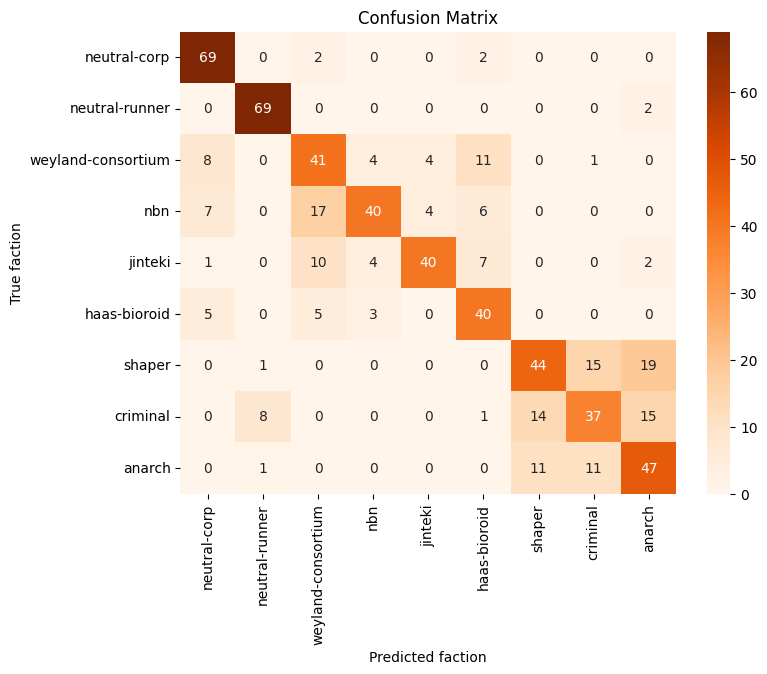

In [ ]:
cm = confusion_matrix(y_nr_test_tf, all_predictions_nr)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Oranges',
            xticklabels=['neutral-corp', 'neutral-runner', 'weyland-consortium', 'nbn', 'jinteki', 'haas-bioroid', 'shaper', 'criminal', 'anarch'],
            yticklabels=['neutral-corp', 'neutral-runner', 'weyland-consortium', 'nbn', 'jinteki', 'haas-bioroid', 'shaper', 'criminal', 'anarch'])
plt.xlabel('Predicted faction')
plt.ylabel('True faction')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
## HS MODEL
##--------------------------------------------------
batch_size = 16

all_predictions = []
all_probabilities = []

## Too Large to do all at once so have to generate predictions in batchs
for i in range(0, x_hs_test_tf['input_ids'].shape[0], batch_size):
    batch_input_data = {
        'input_ids_layer': x_hs_test_tf['input_ids'][i:i + batch_size],
        'token_type_ids_layer': x_hs_test_tf['token_type_ids'][i:i + batch_size],
        'attention_mask_layer': x_hs_test_tf['attention_mask'][i:i + batch_size]
    }

    outputs = hs_model(batch_input_data)
    predicted_labels = np.argmax(outputs, axis=1)
    all_predictions.extend(predicted_labels)

# Convert predictions and probabilities to numpy arrays
all_predictions_hs = np.array(all_predictions)

accuracy = accuracy_score(y_hs_test_tf, all_predictions_hs)
precision = precision_score(y_hs_test_tf, all_predictions_hs, average='weighted')
recall = recall_score(y_hs_test_tf, all_predictions_hs, average='weighted')

print(f'Hearthstone BERT Accuracy: {accuracy:.4f}')
print(f'Hearthstone BERT Precision: {precision:.4f}')
print(f'Hearthstone BERT Recall: {recall:.4f}')

Hearthstone BERT Accuracy: 0.7730
Hearthstone BERT Precision: 0.7775
Hearthstone BERT Recall: 0.7730


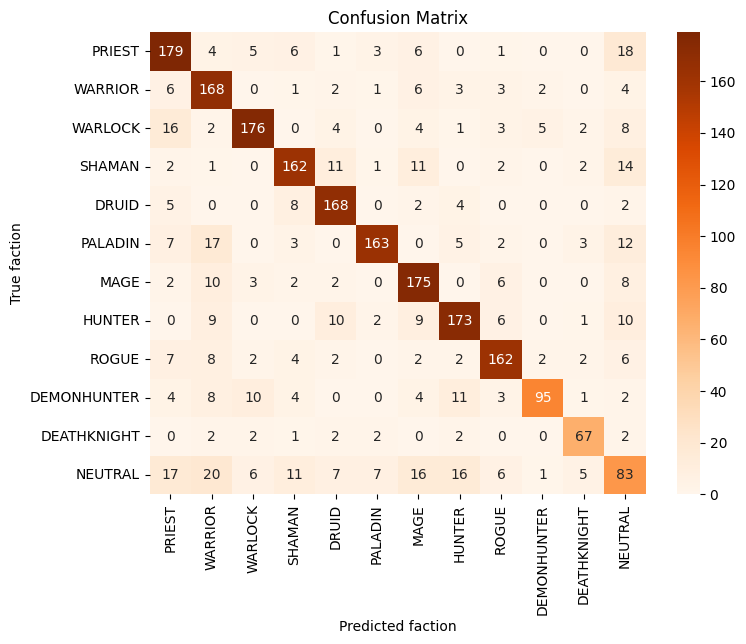

In [ ]:
cm = confusion_matrix(y_hs_test_tf, all_predictions_hs)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Oranges',
            xticklabels=['PRIEST', 'WARRIOR', 'WARLOCK', 'SHAMAN', 'DRUID', 'PALADIN', 'MAGE', 'HUNTER', 'ROGUE', 'DEMONHUNTER', 'DEATHKNIGHT', 'NEUTRAL'],
            yticklabels=['PRIEST', 'WARRIOR', 'WARLOCK', 'SHAMAN', 'DRUID', 'PALADIN', 'MAGE', 'HUNTER', 'ROGUE', 'DEMONHUNTER', 'DEATHKNIGHT', 'NEUTRAL'])
plt.xlabel('Predicted faction')
plt.ylabel('True faction')
plt.title('Confusion Matrix')
plt.show()